# vorticity,  compute and store geostrophic fields


In [10]:
import os, sys, shutil

import numpy as np
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

import dask

import xgcm

import mitequinox.utils as ut
import mitequinox.dynamic as dyn
import mitequinox.plot as pl

In [3]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=12, walltime='12:00:00')
#cluster = PBSCluster(cores=12, walltime='01:00:00')
cluster = PBSCluster(walltime='01:00:00')
w = cluster.scale(jobs=5)
#w = cluster.scale(1*12)
#w = cluster.scale(5) # postprocessing

In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
cluster

---
# load data


In [7]:
bbox = [13, 18, -35, -32]
face = 1

In [59]:
t_start = pd.Timestamp("2012/02/01")
t_end= t_start + pd.Timedelta('30d')

In [60]:
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
ds = ds.sel(time=slice(t_start, t_end), face=face)


#grd = ut.load_grd(V=["XC", "YC", "XG", "YG", "Depth"])
grd = ut.load_grd().drop(['rA','rAw','rAs'])
grd = grd.sel(face=face)

In [61]:
ds = xr.merge([ds, grd])

In [62]:
#grid = xgcm.Grid(ds, periodic=['X', 'Y'])
#grid = xgcm.Grid(ds)

grid = xgcm.Grid(ds, coords={"X": {"center": "i", "left": "i_g"},
                             "Y": {"center": "j", "left": "j_g"},
                            }
                )

grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [63]:
#xgcm.Grid?

In [64]:
# add coriolis parameters to dataset
#omega = 7.3/100000 # XY, 
# see, http://mitgcm.org/public/r2_manual/final/code_reference/vdb/names/R.htm
f = 2*ut.omega_earth*np.sin(np.deg2rad(ds['YG'])) # at vorticity points
f_i = grid.interp(f,'X').chunk({'i':None}) # at v points
f_j = grid.interp(f,'Y').chunk({'j':None}) # at u points
ds = ds.assign_coords(f=f,f_i=f_i,f_j=f_j)

In [65]:
#f[::10,::10].plot()

In [73]:
ds

<xarray.Dataset>
Dimensions:  (time: 721, j: 4320, i_g: 4320, j_g: 4320, i: 4320, k: 90,
              k_p1: 91, k_l: 90, k_u: 90)
Coordinates: (12/34)
  * time     (time) datetime64[ns] 2012-02-01 2012-02-01T01:00:00 ... 2012-03-02
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(16,), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    ...       ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f        (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f_i      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f_j      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

---

## compute vorticity

[doc xgcm](https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html)

In [69]:
def get_vorticity(ds):
    zeta = (-grid.diff(ds.SSU * ds.dxC, 'Y') + grid.diff(ds.SSV * ds.dyC, 'X'))/ds.rAz
    return zeta

In [70]:
_ds = ds.sel(time=t_start)
zeta = get_vorticity(_ds)

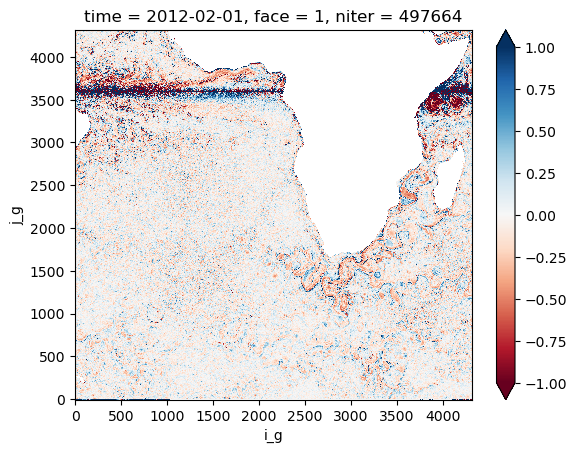

In [76]:
(zeta/ds.f)[::10, ::10].plot(vmin=-1, vmax=1, cmap="RdBu_r")

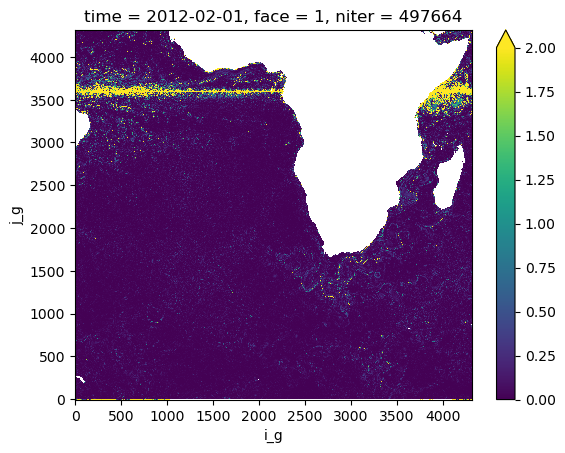

In [77]:
((zeta/ds.f)**2)[::10, ::10].plot(vmax=2)

---

## start computing and storing


- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JC017422
- https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083074



In [89]:
def get_geostrophic_currents(ds):
    detadx = grid.diff(ds["Eta"], "X") / ds.dxC  # d(Eta*g)/dx
    detady = grid.diff(ds["Eta"], "Y") / ds.dyC  # d(Eta*g)/dy
    v =  ut.g * detadx / ds.f_j # @u point
    u = -ut.g * detady / ds.f_i # @v point
    u = grid.interp(u, ["X", "Y"])
    v = grid.interp(v, ["X", "Y"])
    return u, v

In [90]:
u, v = get_geostrophic_currents(_ds)

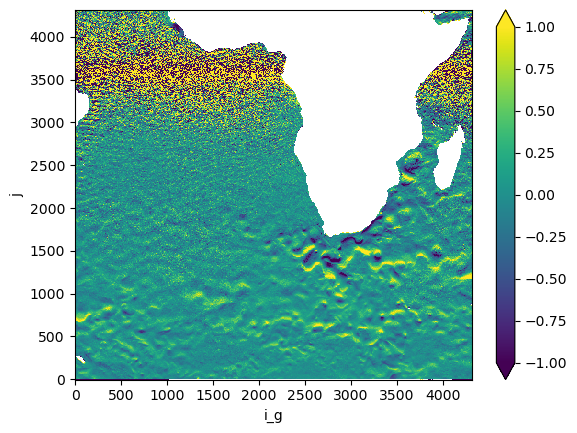

In [94]:
u[::10, ::10].plot(vmin=-1, vmax=1)

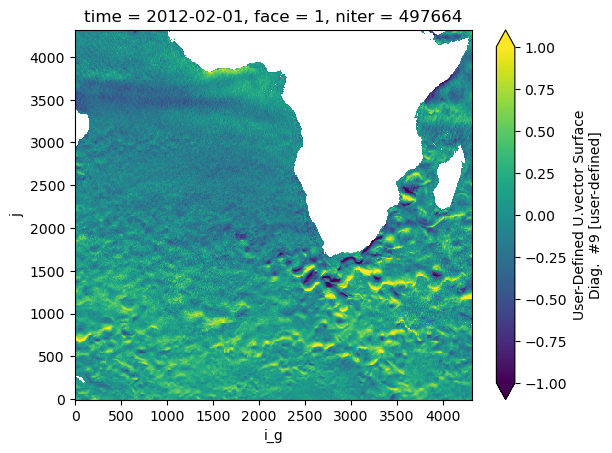

In [95]:
_ds.SSU[::10, ::10].plot(vmin=-1, vmax=1)

In [99]:
ds["SSU_geo"], ds["SSV_geo"] = get_geostrophic_currents(ds)
ds

<xarray.Dataset>
Dimensions:  (time: 721, j: 4320, i_g: 4320, j_g: 4320, i: 4320, k: 90,
              k_p1: 91, k_l: 90, k_u: 90)
Coordinates: (12/34)
  * time     (time) datetime64[ns] 2012-02-01 2012-02-01T01:00:00 ... 2012-03-02
    face     int64 1
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(16,), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    ...       ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f        (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f_i      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    f_j      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSU_geo  (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV_geo  (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

- stocker les champs
- aller chercher les positions des uplets des zones d'intérêt
- configurer parcels

---

In [7]:
terms = ['u_coriolis_linear','u_gradp', 'v_coriolis_linear','v_gradp']
terms = ['v_coriolis_linear']

In [8]:
#Nt, Ni, Nj = 24*20, 188, 96
Nt, Ni, Nj = 24*40, 376, 188

/home/mp/pontea/.conda/envs/equinox/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [9]:
overwrite=True

for face in range(11,12):

    print('--- start processing face %d'%face)
    ds = ds0.sel(face=face)

    for t in terms:
        
        bterm = get_mbal(t, ds, grid)

        if t[0]=='u':
            chunks = {'time': Nt, 'i_g': Ni, 'j': Nj}
        elif t[0]=='v':
            chunks = {'time': Nt, 'i': Ni, 'j_g': Nj}
        bterm = bterm.isel(time=slice(len(ds.time)//Nt *Nt))
        bterm = bterm.chunk(chunks)

        file_out = work_data_dir+'mbal/%s_f%02d.zarr'%(t,face)
        if not os.path.isdir(file_out) or overwrite:
            bterm.to_dataset().to_zarr(file_out, mode='w')
        print('  %s, face=%d - processed'%(t, face))

print('mbal terms computed for face=%d'%(face))

--- start processing face 11
  v_coriolis_linear, face=11 - processed
mbal terms computed for face=11


In [11]:
cluster.close()

---

## check result

In [15]:
#t = terms[0]
#face = 1
for face in range(13):
    t = terms[0]
    #for t in terms:
    ds = xr.open_zarr(work_data_dir+'mbal/%s_f%02d.zarr'%(t,face))
    print(np.abs(ds[t]).mean().values)
    #print(ds)
    print('face = %d, term = %s'%(face,t))

8.808109e-06
face = 0, term = u_coriolis_linear
1.1890352e-05
face = 1, term = u_coriolis_linear
1.6254831e-05
face = 2, term = u_coriolis_linear
1.42116005e-05
face = 3, term = u_coriolis_linear
1.1237888e-05
face = 4, term = u_coriolis_linear
1.2675767e-05
face = 5, term = u_coriolis_linear
8.593417e-06
face = 6, term = u_coriolis_linear
1.4433777e-05
face = 7, term = u_coriolis_linear
1.1593577e-05
face = 8, term = u_coriolis_linear
1.353924e-05
face = 9, term = u_coriolis_linear
1.5262634e-05
face = 10, term = u_coriolis_linear
1.2627581e-05
face = 11, term = u_coriolis_linear
1.605496e-05
face = 12, term = u_coriolis_linear


In [8]:
face=1
t = terms[0]
ds = xr.open_zarr(work_data_dir+'mbal/%s_f%02d.zarr'%(t,face))

In [11]:
ds

<xarray.Dataset>
Dimensions:            (i_g: 4320, j: 4320, time: 8640)
Coordinates:
    dxC                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    dyG                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    f_j                (j, i_g) float32 dask.array<shape=(4320, 4320), chunksize=(188, 376)>
    face               int64 ...
  * i_g                (i_g) int64 0 1 2 3 4 5 ... 4314 4315 4316 4317 4318 4319
  * j                  (j) int64 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
  * time               (time) float64 5.702e+06 5.706e+06 ... 3.68e+07 3.68e+07
Data variables:
    u_coriolis_linear  (j, i_g, time) float32 dask.array<shape=(4320, 4320, 8640), chunksize=(188, 376, 960)>

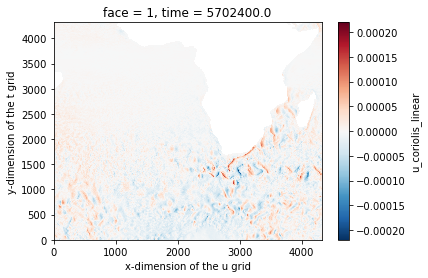

In [12]:
ds[t].isel(time=0).plot()

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [100]:
cluster.close()